# UDLF Non-Local Means (LHRR)
Images and data collected from experiments of UDLF Non-Local Means with LHRR as the reranking method used.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

%matplotlib inline

from skimage import data
from skimage.color import rgb2gray
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage.util import random_noise

from nlmeans.nlmeans import nlmeans
from nlmeans.nlmeans_udlf import nlmeans_udlf

## Parameters

In [2]:
# Non-Local Means parameters
hW = 10        # Window Size
hP = 3         # Patch Size
tau = 0.15     # Contribution of similarity on noisy-data
sig = 0.1      # Standard deviation of the gaussian noise
shape = 'disk' # Patch shape
n_w = None     # Number of weights to use or use all(None)

# Image to test with
image = 'astronaut'

# UDLF Parameters
udl_method = 'LHRR'
udl_params = {
    'k': 3,
    't': 1
}

### Remove temporary files
Auxiliar function used to remove the temporary files created by UDLF.

In [3]:
def rm_tmp_files():
    tmp_files = ['input.txt', 'list.txt', 'log.txt', 'output.txt']
    for tmp_file in tmp_files:
        try:
            os.remove(tmp_file)
        except FileNotFoundError:
            pass

## Image preprocessing
Get the image from skimage dataset or use the image from the local file system if not found in skimage. 

After that, do the necessary preprocessing:
- Crop the image to be 200x200 (This is necessary because UDLF has to be able to allocate memory to process the 
  ranked lists gotten from the image. In a system with more memory the image can possibly be greater);
- Convert the image from RGB to Grayscale.

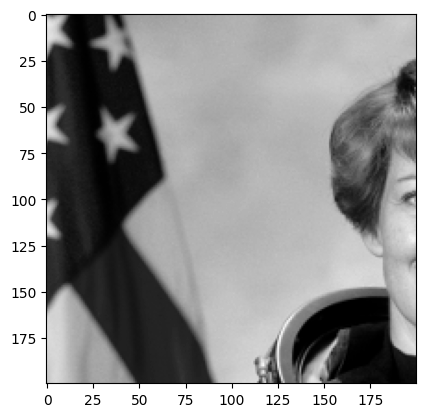

In [4]:
images = ('astronaut',
          'binary_blobs',
          'colorwheel',
          'cat',
          'coffee',
          'eagle',
          'horse',
          'logo',
          'page',
          'text',
          'rocket',
         )

if image in images:
    im = getattr(data, image)()
    #im = im[100:300, 100:300]
    im = im[0:200, 0:200]
    im_name = image
else:
    im = plt.imread(image).astype('float')
    im_name = os.path.splitext(os.path.basename(image))[0]

if len(im.shape) == 3:
    im = rgb2gray(im)

# Show the image
plt.imshow(im, cmap='gray')

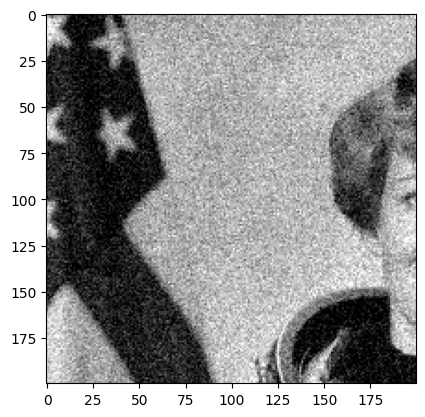

In [5]:
im_nse = random_noise(im, var = sig**2)
sigma_est = np.mean(estimate_sigma(im_nse, channel_axis=-1))
plt.imshow(im_nse, cmap='gray')

## Non-Local Means SAP
For comparison the Non-Local Means SAP (the algorithm on which UDLF Non-Local Means is based) is run as well. 

CPU times: user 1.54 s, sys: 7.21 ms, total: 1.54 s
Wall time: 1.54 s


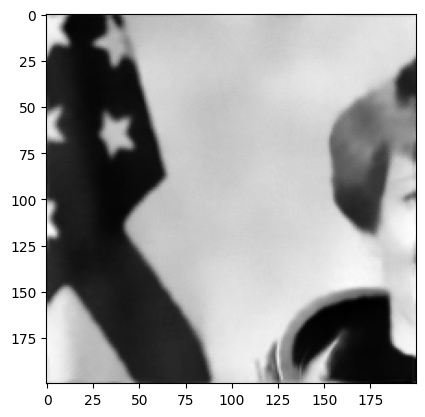

In [6]:
%%time
im_fil1 = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)
plt.imshow(im_fil1, cmap='gray')

## UDLF Non-Local Means (NONE)
The results of the reranking method will be compared with Non-Local Means using the original ranked lists, that is, the ranked lists used as input to UDLF. 

CPU times: user 15 s, sys: 990 ms, total: 16 s
Wall time: 16.1 s


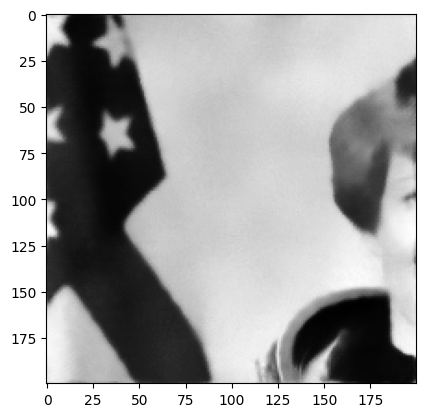

In [7]:
%%time
im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, 'NONE', None, n_w)
rm_tmp_files()
plt.imshow(im_fil3, cmap='gray')

## UDLF Non-Local Means (LHRR)
This denoise the image using LHRR as the reranking method and considering RLRECOM default parameters as indicated in the [UDLF config.ini](https://github.com/UDLF/UDLF/blob/master/bin/config.ini)

CPU times: user 16.2 s, sys: 959 ms, total: 17.2 s
Wall time: 40.1 s


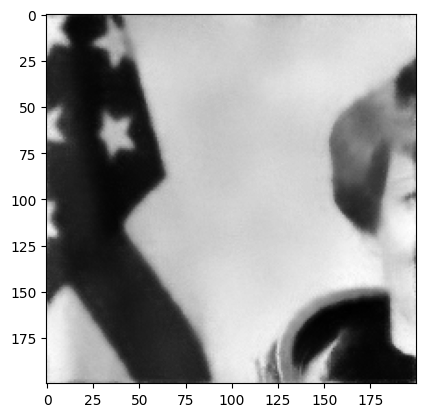

In [8]:
%%time
im_fil2 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
rm_tmp_files()
plt.imshow(im_fil2, cmap='gray')

### Show the images side by side

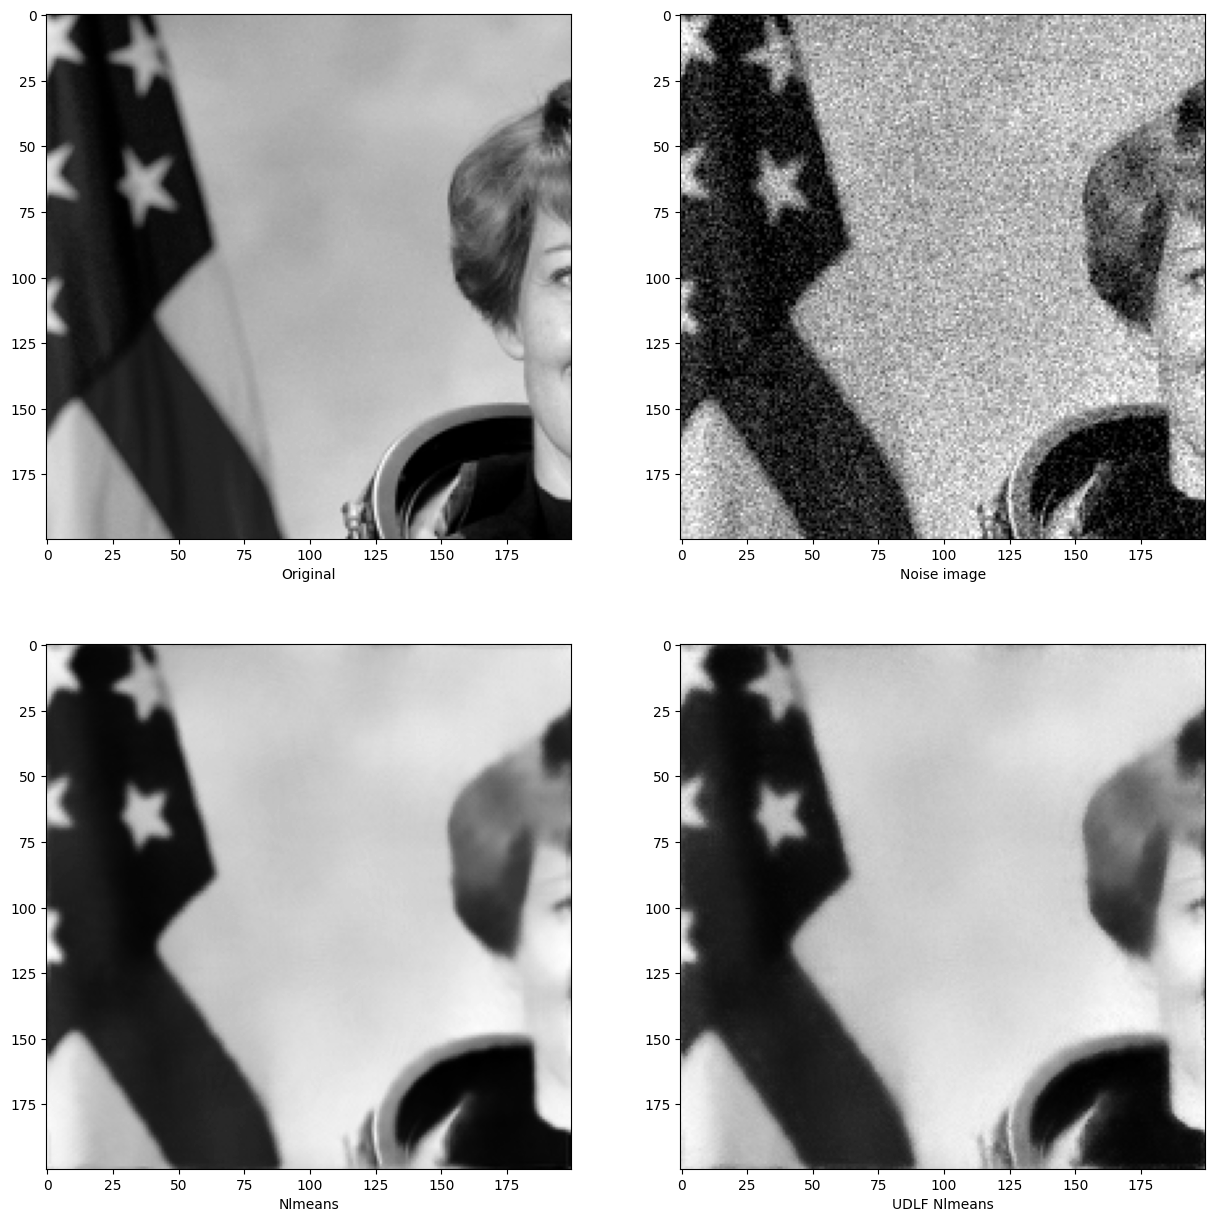

,Noise,Nlmeans,LHRR Nlmeans,NONE Nlmeans
PSNR,20.439953,27.132703,26.558013,26.972510
SSIM,0.289384,0.831339,0.814049,0.819368
MSE,0.009037,0.001309,0.001487,0.001354


In [9]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
plt.subplot(2, 2, 1)
plt.xlabel('Original')
plt.imshow(im, cmap='gray')
plt.subplot(2, 2, 2)
plt.xlabel('Noise image')
plt.imshow(im_nse, cmap='gray')
plt.subplot(2, 2, 3)
plt.xlabel('Nlmeans')
plt.imshow(im_fil1, cmap='gray')
plt.subplot(2, 2, 4)
plt.xlabel('UDLF Nlmeans')
plt.imshow(im_fil2, cmap='gray')
plt.show()

# Updates the figsize
plt.rcParams['figure.figsize'] = [15, 5]

im_noise_psnr = psnr(im, im_nse, data_range=im_nse.max() - im_nse.min())
im_noise_ssim = ssim(im, im_nse, data_range=im_nse.max() - im_nse.min())
im_noise_mse  = mse(im, im_nse)

im_nlm_psnr   = psnr(im, im_fil1, data_range=im_fil1.max() - im_fil1.min())
im_nlm_ssim   = ssim(im, im_fil1, data_range=im_fil1.max() - im_fil1.min())
im_nlm_mse    = mse(im, im_fil1)

im_udlf_psnr  = psnr(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_ssim  = ssim(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_mse   = mse(im, im_fil2)

im_none_psnr  = psnr(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
im_none_ssim  = ssim(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
im_none_mse   = mse(im, im_fil3)

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_udlf_mse,  im_none_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', 'LHRR Nlmeans', 'NONE Nlmeans'],
)

## Hyperparameters Tuning
The last experiment was runned using the default parameters which can be not the best. The next section tries to find the best value to each of the parameters accepted by the reranking method.

All the tests will be made considering PSNR as the value to be maximized.

In [10]:
%%time
# K parameter
# For speed porpuses only a subset of the values accepted by k will be tested (testing all the possible values for k
# could spend up to 80 hours).
start    = 3
end      = 20
step     = 1
possible_values = range(start, end, step)
iter_num = len(possible_values)
psnrs    = np.zeros(iter_num)
psnr_max = 0
best_k   = start
best_im  = None

for i, k in enumerate(possible_values):
    udl_params['k'] = k
    try:
        im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
        rm_tmp_files()
        psnr_value = psnr(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
        if psnr_value > psnr_max:
            psnr_max = psnr_value
            best_k   = k
            best_im  = im_fil3
        psnrs[i] = psnr_value
    except:
        print('Finished with error on param:', k)
        break
        
# Update method parameters
udl_params['k'] = best_k
print('params:', udl_params)
print('PSNR:', psnr_max)

params: {'k': 3, 't': 1}
PSNR: 26.558013213138878
CPU times: user 4min 39s, sys: 13.6 s, total: 4min 53s
Wall time: 15min 31s


Text(0, 0.5, 'PSNR')

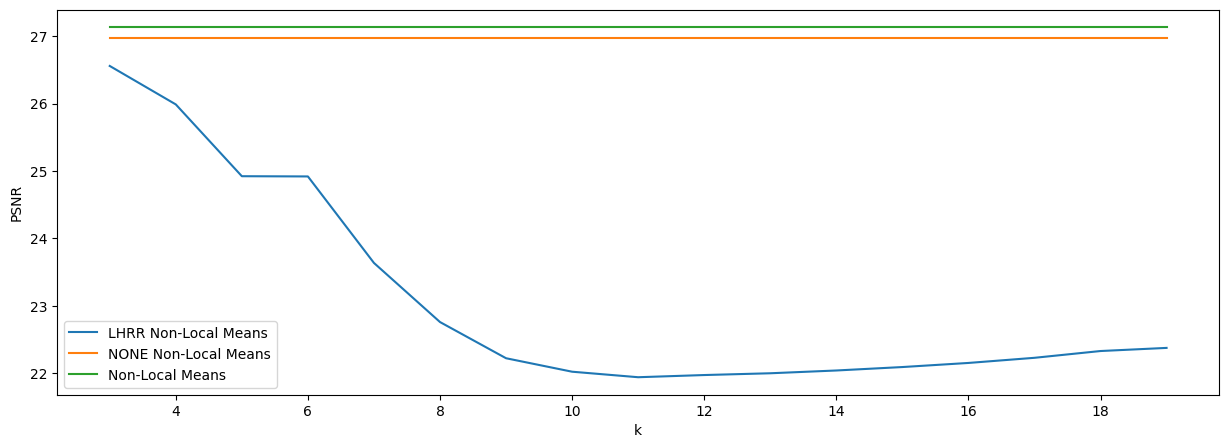

In [11]:
udlf_plot, = plt.plot(possible_values, psnrs, label = 'LHRR Non-Local Means')
none_plot, = plt.plot(possible_values, [im_none_psnr] * iter_num, label = 'NONE Non-Local Means')
nlm_plot,  = plt.plot(possible_values, [im_nlm_psnr] * iter_num, label = 'Non-Local Means')
plt.legend(handles = [udlf_plot, none_plot, nlm_plot])
plt.xlabel('k')
plt.ylabel('PSNR')

### t

In [12]:
%%time
start    = 1
end      = 5
step     = 1
possible_values = range(start, end, step)
iter_num = len(possible_values)
psnrs    = np.zeros(iter_num)
best_t   = start

for i, t in enumerate(possible_values):
    udl_params['t'] = t
    try:
        im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
        rm_tmp_files()
        psnr_value = psnr(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
        if psnr_value > psnr_max:
            psnr_max = psnr_value
            best_t   = t
            best_im  = im_fil3
        psnrs[i] = psnr_value
    except:
        print('Finished with error on param:', k)
        break
        
# Update method parameters
udl_params['t'] = best_t
print('params:', udl_params)
print('PSNR:', psnr_max)

params: {'k': 3, 't': 1}
PSNR: 26.558013213138878
CPU times: user 1min 3s, sys: 3.02 s, total: 1min 6s
Wall time: 3min 40s


Text(0, 0.5, 'PSNR')

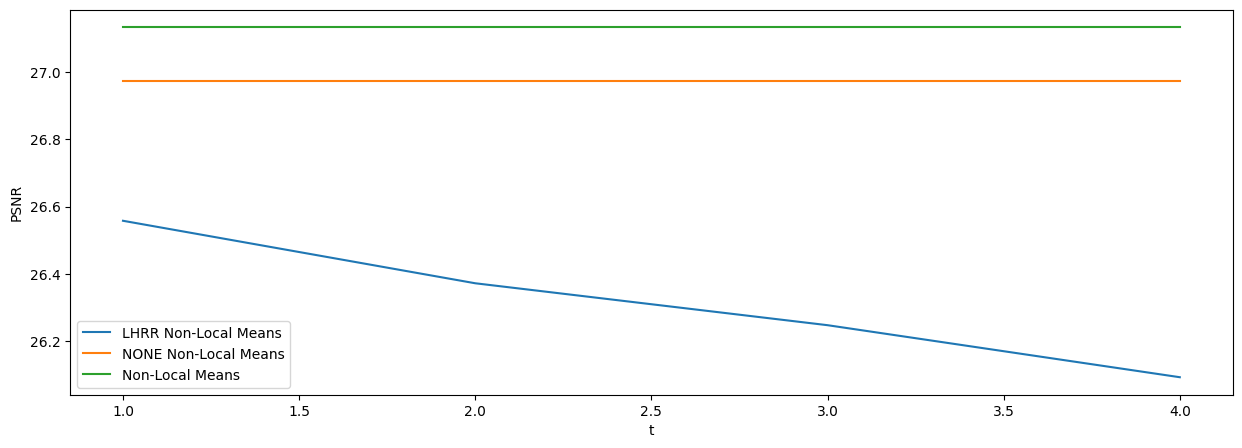

In [13]:
udlf_plot, = plt.plot(possible_values, psnrs, label = 'LHRR Non-Local Means')
none_plot, = plt.plot(possible_values, [im_none_psnr] * iter_num, label = 'NONE Non-Local Means')
nlm_plot,  = plt.plot(possible_values, [im_nlm_psnr] * iter_num, label = 'Non-Local Means')
plt.legend(handles = [udlf_plot, none_plot, nlm_plot])
plt.xlabel('t')
plt.ylabel('PSNR')

### Final Result

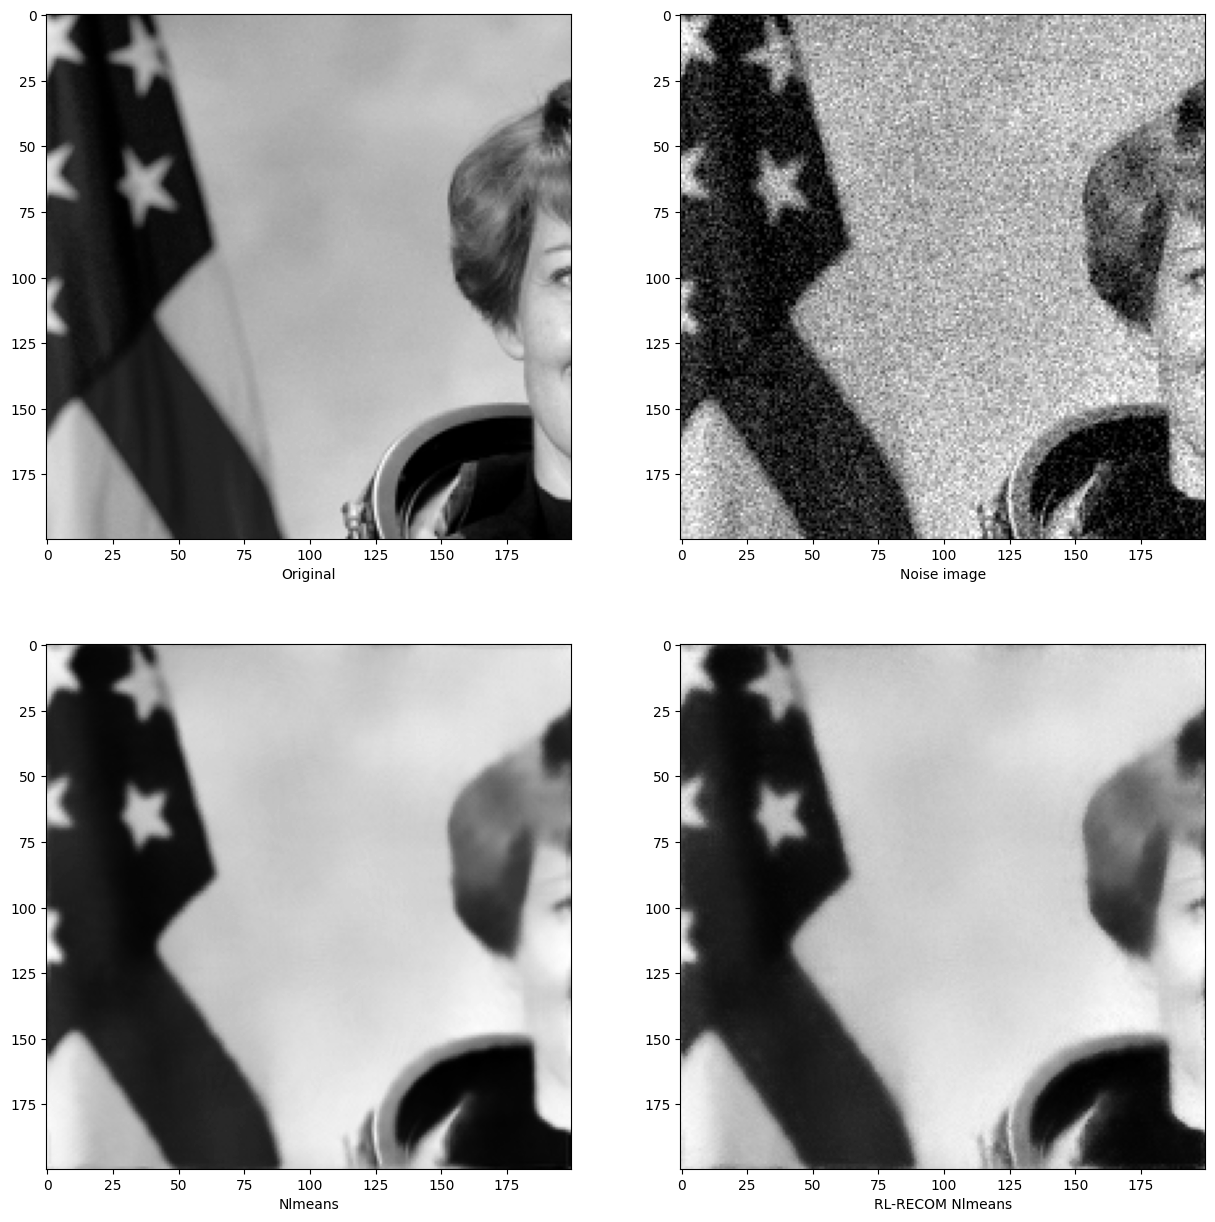

,Noise,Nlmeans,RL-RECOM Nlmeans,NONE Nlmeans
PSNR,20.439953,27.132703,26.558013,26.972510
SSIM,0.289384,0.831339,0.814049,0.819368
MSE,0.009037,0.001309,0.001487,0.001354


In [14]:
im_fil2 = best_im

plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
plt.subplot(2, 2, 1)
plt.xlabel('Original')
plt.imshow(im, cmap='gray')
plt.subplot(2, 2, 2)
plt.xlabel('Noise image')
plt.imshow(im_nse, cmap='gray')
plt.subplot(2, 2, 3)
plt.xlabel('Nlmeans')
plt.imshow(im_fil1, cmap='gray')
plt.subplot(2, 2, 4)
plt.xlabel('RL-RECOM Nlmeans')
plt.imshow(best_im, cmap='gray')
plt.show()

# Updates the figsize
plt.rcParams['figure.figsize'] = [15, 5]

# Recalculates for UDLF
im_udlf_psnr  = psnr(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_ssim  = ssim(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_mse   = mse(im, im_fil2)

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_udlf_mse,  im_none_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', 'RL-RECOM Nlmeans', 'NONE Nlmeans'],
)

## Experiments with other images
Given the images tuple containing a subset of the images in skimage.data, denoise will be made in all these images to compare in the end if the UDLF Non-Local Means algorithm was positive in all of them. 

In [ ]:
%%time
import sys

eval_info = []
eval_psnr = []
images_tested = []
print('Method:', udl_method)
print('Parameters:', udl_params)

for image in images:
    # Preprocessing
    try:
        im = getattr(data, image)()
    except ModuleNotFoundError:
        print('[err] Could not run test for image:', image, file=sys.stderr)
        continue
    
    # Cuts the image to be a square image with 200x200 pixels max
    if im.shape[0] > 200:
        if im.shape[1] < 200:
            im = im[0:im.shape[1], :]
        else:
            im = im[0:200, :]
    
    if im.shape[1] > 200:
        if im.shape[0] < 200:
            im = im[:, 0:im.shape[0]]
        else:
            im = im[:, 0:200]
        
    if im.shape[0] != im.shape[1]:
        print('[err] Invalid Shape on image:', image, im.shape, file=sys.stderr)
        continue
    
    try:
        if len(im.shape) == 3:
            im = rgb2gray(im)
    except ValueError:
        print('[err]rgb2gray on image:', image, im.shape, file=sys.stderr)
        continue
    
    # Add noise
    im_nse = random_noise(im, var = sig**2)
    sigma_est = np.mean(estimate_sigma(im_nse, channel_axis=-1))
    
    ## Nlmeans
    im_fil1 = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)

    ## UDLF Nlmeans
    im_fil2 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
    rm_tmp_files()
    
    ## NONE Nlmeans
    im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, 'NONE', None, n_w)
    rm_tmp_files() 

    # Evaluation
    im_noise_psnr = psnr(im, im_nse, data_range=im_nse.max() - im_nse.min())
    im_noise_ssim = ssim(im, im_nse, data_range=im_nse.max() - im_nse.min())
    im_noise_mse  = mse(im, im_nse)

    im_nlm_psnr   = psnr(im, im_fil1, data_range=im_fil1.max() - im_fil1.min())
    im_nlm_ssim   = ssim(im, im_fil1, data_range=im_fil1.max() - im_fil1.min())
    im_nlm_mse    = mse(im, im_fil1)

    im_udlf_psnr  = psnr(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
    im_udlf_ssim  = ssim(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
    im_udlf_mse   = mse(im, im_fil2)
    
    im_none_psnr  = psnr(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
    im_none_ssim  = ssim(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
    im_none_mse   = mse(im, im_fil3)

    eval_info.append([im_noise_psnr, im_noise_ssim, im_noise_mse,
                      im_nlm_psnr, im_nlm_ssim, im_nlm_mse,
                      im_udlf_psnr, im_udlf_ssim, im_udlf_mse,
                      im_none_psnr, im_none_ssim, im_none_mse])
    
    eval_psnr.append([im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr])
    
    images_tested.append(image)
    print('Tested with image:', image, im.shape)

Method: LHRR
Parameters: {'k': 3, 't': 1}
Tested with image: astronaut (200, 200)
Tested with image: binary_blobs (200, 200)
Tested with image: colorwheel (200, 200)
Tested with image: cat (200, 200)
Tested with image: coffee (200, 200)
Tested with image: eagle (200, 200)
Tested with image: horse (200, 200)


[err]rgb2gray on image: logo (200, 200, 4)


Tested with image: page (191, 191)
Tested with image: text (172, 172)


### Show the results

In [ ]:
pd.DataFrame(
    data = eval_psnr,
    index = images_tested,
    columns = ['Noise', 'Nlmeans', 'LHRR', 'NONE']
)

#pd.DataFrame(
#    data    = eval_info,
#    index   = images,
#    columns = ['PSNR Noise', 'SSIM Noise', 'MSE Noise', 
#               'PSNR Nlmeans', 'SSIM Nlmeans', 'MSE Nlmeans',
#               'PSNR RL-RECOM Nlmeans', 'SSIM RL-RECOM Nlmeans', 'MSE RL-RECOM Nlmeans',
#               'PSNR NONE Nlmeans', 'SSIM NONE Nlmeans', 'MSE NONE Nlmeans']
#)